# Applied data analysis P4 a)

In [1]:
import pandas as pd
import sklearn as sk
import numpy as np
from numpy import interp

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC, LinearSVC
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

from collections import Counter
from imblearn.datasets import fetch_datasets
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Prepare the data of each regression method

In [3]:
#read the data
data = pd.read_csv('CivilWarOnset/SambnisImp.csv')

### When loading the data for replication purposes, note that the authors only load the following 91 variables:

In [4]:
df = data[["ager", "agexp", "anoc", "army85", "autch98", "auto4",
    "autonomy", "avgnabo", "centpol3", "coldwar", "decade1", "decade2",
    "decade3", "decade4", "dem", "dem4", "demch98", "dlang", "drel", "durable",
    "ef", "ef2", "ehet", "elfo", "elfo2", "etdo4590", "expgdp", "exrec",
    "fedpol3", "fuelexp", "gdpgrowth", "geo1", "geo2", "geo34", "geo57",
    "geo69", "geo8", "illiteracy", "incumb", "infant", "inst", "inst3", "life",
    "lmtnest", "ln_gdpen", "lpopns", "major", "manuexp", "milper", "mirps0",
    "mirps1", "mirps2", "mirps3", "nat_war", "ncontig", "nmgdp", "nmdp4_alt",
    "numlang", "nwstate", "oil", "p4mchg", "parcomp", "parreg", "part",
    "partfree", "plural", "plurrel", "pol4", "pol4m", "pol4sq", "polch98",
    "polcomp", "popdense", "presi", "pri", "proxregc", "ptime", "reg",
    "regd4_alt", "relfrac", "seceduc", "second", "semipol3", "sip2", "sxpnew",
    "sxpsq", "tnatwar", "trade", "warhist", "xconst"]]

#Take the variables that were used in each logistic regression method
# Model 1: Fearon and Laitin (2003):
df_FearonLaitin = data[["warhist", "ln_gdpen", "lpopns", "lmtnest", "ncontig", "oil", "nwstate", "inst3", "pol4", "ef", "relfrac"]]

# Model 2: Collier and Hoeffler (2004):
df_CollierHoeffler = data[["sxpnew", "sxpsq", "ln_gdpen", "gdpgrowth", "warhist", "lmtnest", "ef", "popdense", "lpopns", "coldwar", "seceduc", "ptime"]]

# Model 3: Hegre and Sambanis (2006):
df_HegreSambanis = data[["lpopns", "ln_gdpen", "inst3", "parreg", "geo34",
    "proxregc", "gdpgrowth", "anoc", "partfree", "nat_war", "lmtnest",
    "decade1", "pol4sq", "nwstate", "regd4_alt", "etdo4590", "milper", "geo1",
    "tnatwar", "presi"]]

#Dependent variable Y, binary measure of whether a civil war onset occurred for a given country, i, in a given year j.
dep_var = data['warstds']

### Data correction

In this extension we aim to improve the overall predictive performance of civil war onset by exploring data correction methods for imbalanced datasets.

### Cros validation function
This function does 10 fold cross validation based on the passed input classifier type and sampling method and outputs the True and False Positive Rates, F1 and AUC scores. The idea is to get the true positive rate for each fold and calculate the mean of it to get the 10-fold cross-validation.

In [5]:
def roc_10fold_crossvalidation(X, y, classifier, sampling=None):

    #Kfold will split the data in 10 folds
    kf = KFold(n_splits=10)
    #create a linespace to interpolate the positive rate with it (it will smoothe the curve)
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    f1s = []
    #Loop that iterates over each folds
    for train, test in kf.split(X):
        
        #Uses 9 folds for training data and 1 fold for test data 
        X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
        
        if sampling:
            model = make_pipeline_imb(sampling(),classifier)
            model.fit(X_train, y_train)
        else:
            model = classifier
            model.fit(X_train, y_train)

        # Predict the probabilities
        y_pred = model.predict_proba(X_test)
        y_pred_2 = model.predict(X_test)

        # Keep only positive probabilities outcome
        y_pred = y_pred[:, 1]
    
        # Calculate roc, f1 score 
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        f1 = f1_score(y_test, y_pred_2)
        f1s.append(f1)
        
        # Do the interpolation with positive rates
        tprs.append(interp(mean_fpr, fpr, tpr)) 
        tprs[-1][0] = 0.0

    # Make the mean of the true positive rates
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_f1 = np.mean(f1s)
    
    return (mean_fpr, mean_tpr, mean_f1)

First we replicate the results of the paper for the three logistic regression models using no sampling, oversampling and undersamping of the features.

Then we do the same for Random forests.

We also apply ADA Boosting and plot the results for all the previously mentioned models.

LR no sampling
LR oversampling
LR undersampling
LR no sampling + adaboost
LR oversampling + adaboost
LR undersampling + adaboost
RF


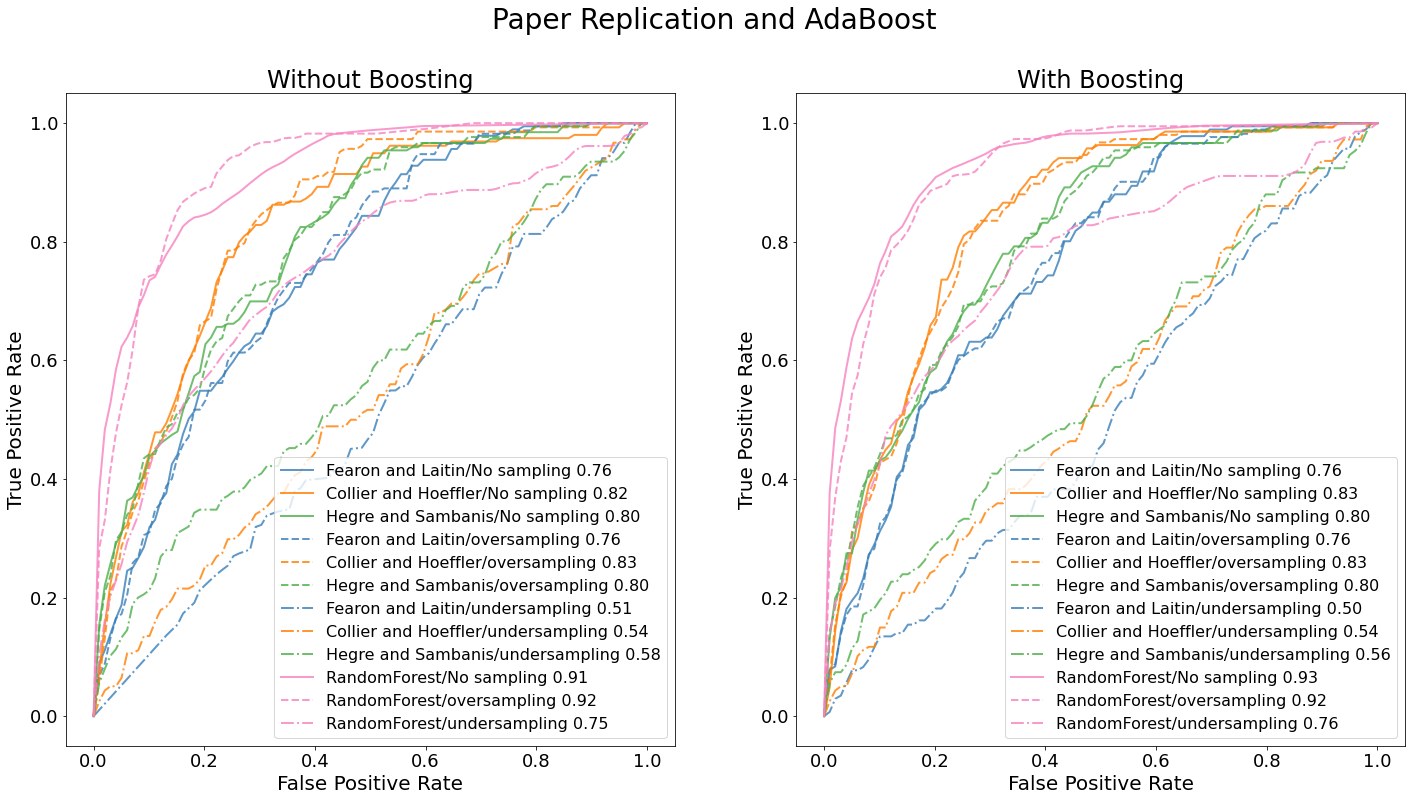

In [6]:
# Convert the df for each method into numpy array
X = [df_FearonLaitin.to_numpy(), df_CollierHoeffler.to_numpy(), df_HegreSambanis.to_numpy(), df.to_numpy()]
# Convert the dependent into numpy array (same for the 3 methods)
y = dep_var.to_numpy()

linestyle = ['-','--','-.']
# Name of the logistic regression methods
method_name = ['Fearon and Laitin', 'Collier and Hoeffler', 'Hegre and Sambanis']
# Colorblind color palette
color = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']
#sampling_names=['No sampling', 'SMOTE (oversampling)', 'NearMiss (undersampling)']
sampling_names=['No sampling', 'oversampling', 'undersampling']

sampling_methods=[None, SMOTE, NearMiss]

# Create a multiplot
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(24,12))

print('LR no sampling')
# Plot the 3 methods without sampling methods
for i in range(0,3):
    #The l2 penalization should give results similar to the Firth rare event 
    # 10-fold cross-validation logistic regression, with no penalties
    mean_fpr,mean_tpr, mean_f1 = roc_10fold_crossvalidation(X[i],y, LogisticRegression(random_state=42, penalty='none', max_iter=100000), None )
    #print(mean_f1)
    # Calculate the auc score
    mean_auc = auc(mean_fpr,mean_tpr)
    # Plot ROC and auc score in the legends, rounded up to 2 decimals
    ax1.plot(mean_fpr, mean_tpr, color=color[i], label=method_name[i]+'/'+ sampling_names[0]+' %.2f'%mean_auc, lw=2, alpha=.8)

print('LR oversampling')
# Plot the 3 methods with oversampling
for i in range(0,3):
    mean_fpr,mean_tpr, mean_f1 = roc_10fold_crossvalidation(X[i],y, LogisticRegression(random_state=42, penalty='none', max_iter=100000), SMOTE)   
    #print(mean_f1)
    mean_auc = auc(mean_fpr,mean_tpr)
    ax1.plot(mean_fpr, mean_tpr, color=color[i], ls='--', label=method_name[i]+'/'+sampling_names[1]+ ' %.2f'%mean_auc, lw=2, alpha=.8)

print('LR undersampling')    
# Plot the 3 methods with undersampling
for i in range(0,3):
    mean_fpr,mean_tpr, mean_f1 = roc_10fold_crossvalidation(X[i],y, LogisticRegression(random_state=42, penalty='none', max_iter=100000), NearMiss)
    #print(mean_f1)
    mean_auc = auc(mean_fpr,mean_tpr)
    ax1.plot(mean_fpr, mean_tpr, color=color[i], ls='-.', label=method_name[i]+'/'+sampling_names[2]+ ' %.2f'%mean_auc, lw=2, alpha=.8)    
    
print('LR no sampling + adaboost')    
# Plot the 3 methods without sampling methods, and AdaBoost 
for i in range(0,3):
    # 10-fold cross-validation 
    mean_fpr,mean_tpr, mean_f1 = roc_10fold_crossvalidation(X[i],y, AdaBoostClassifier(LogisticRegression(random_state=42, penalty='none', max_iter=100000), n_estimators=100, random_state=0), None )
    #print(mean_f1)
    # Calculate the auc score
    mean_auc = auc(mean_fpr,mean_tpr)
    # Plot and and auc score ine the legends, rounded up to 2 decimals
    ax2.plot(mean_fpr, mean_tpr, color=color[i], label=method_name[i]+'/'+sampling_names[0]+' %.2f'%mean_auc, lw=2, alpha=.8) 
    
print('LR oversampling + adaboost')    
# Plot the 3 methods with oversampling, and AdaBoost
for i in range(0,3):
    # 10-fold cross-validation 
    mean_fpr,mean_tpr, mean_f1 = roc_10fold_crossvalidation(X[i],y, AdaBoostClassifier(LogisticRegression(random_state=42, penalty='none', max_iter=100000), n_estimators=100, random_state=0), SMOTE )
    #print(mean_f1)
    # Calculate the auc score
    mean_auc = auc(mean_fpr,mean_tpr)
    # Plot and and auc score ine the legends, rounded up to 2 decimals
    ax2.plot(mean_fpr, mean_tpr, color=color[i], ls='--', label=method_name[i]+'/'+sampling_names[1]+' %.2f'%mean_auc, lw=2, alpha=.8)    

print('LR undersampling + adaboost')    
    # Plot the 3 methods with undersampling, and AdaBoost
for i in range(0,3):
    # 10-fold cross-validation 
    mean_fpr,mean_tpr, mean_f1 = roc_10fold_crossvalidation(X[i],y, AdaBoostClassifier(LogisticRegression(random_state=42, penalty='none', max_iter=100000), n_estimators=1000, random_state=0), NearMiss )
    #print(mean_f1)
    # Calculate the auc score
    mean_auc = auc(mean_fpr,mean_tpr)
    # Plot and and auc score ine the legends, rounded up to 2 decimals
    ax2.plot(mean_fpr, mean_tpr, color=color[i], ls='-.', label=method_name[i]+'/'+sampling_names[2]+' %.2f'%mean_auc, lw=2, alpha=.8)
    
print('RF')    
#random forest 
for i in range(0,3):
    # 10-fold cross-validation Random forests
    mean_fpr,mean_tpr, mean_f1 = roc_10fold_crossvalidation(X[3],y, RandomForestClassifier(random_state=42), sampling_methods[i])
    #print(mean_f1)
    # Calculate the auc score
    mean_auc = auc(mean_fpr,mean_tpr)
    # Plot ROC and auc score in the legends, rounded up to 2 decimals
    ax1.plot(mean_fpr, mean_tpr, color=color[3], ls=linestyle[i], label='RandomForest'+'/'+sampling_names[i] +' %.2f'%mean_auc, lw=2, alpha=.8)
# Plot the 3 methods with uncorrected Logits 
for i in range(0,3):    
    # 10-fold cross-validation Random forests
    mean_fpr,mean_tpr, mean_f1 = roc_10fold_crossvalidation(X[3],y, AdaBoostClassifier(RandomForestClassifier(random_state=42), n_estimators=100, random_state=0), sampling_methods[i])
    #print(mean_f1)
    # Calculate the auc score
    mean_auc = auc(mean_fpr,mean_tpr)
    # Plot and and auc score ine the legends, rounded up to 2 decimals
    ax2.plot(mean_fpr, mean_tpr, color=color[3], ls=linestyle[i], label='RandomForest'+'/'+sampling_names[i] +' %.2f'%mean_auc, lw=2, alpha=.8)

fig.suptitle('Paper Replication and AdaBoost', fontsize=28)

# Set axis labels
ax1.set_ylabel('True Positive Rate', fontsize = 20) # Y label
ax1.set_xlabel('False Positive Rate', fontsize = 20) # X label
ax2.set_ylabel('True Positive Rate', fontsize = 20) # Y label
ax2.set_xlabel('False Positive Rate', fontsize = 20) # X label

# Set titles
ax1.set_title('Without Boosting', fontsize = 24)
ax2.set_title('With Boosting', fontsize = 24)
ax1.tick_params(labelsize=18)
ax2.tick_params(labelsize=18)

# Show the legend (loc 4 is bottom-right)
ax1.legend(loc=4, fontsize = 16)
ax2.legend(loc=4, fontsize = 16)    
plt.savefig('LR_replication.png', dpi=1200)
plt.show()

# Models with all features

From now on, we consider all provided features and use them to build the classfiers models.
First we start with Logistic regression and Random Forest by building and comparing their results with no sampling and oversampling.

Again we apply ADA Boosting and plot the results.

Note that from now on we do not apply undersampling, as we concluded from the figures above and the calculated AUC scores, that it does not contribute to improving the predective performance of the classifiers, but makes it much worse.

# 1) Logistic Regression and Random Forest

LR
0.0
0.08043503521906337
0.007692307692307691
0.08382843803400147
RF
0.12668199018044218
0.21311108246592117
0.1504834054834055
0.2114122926622927


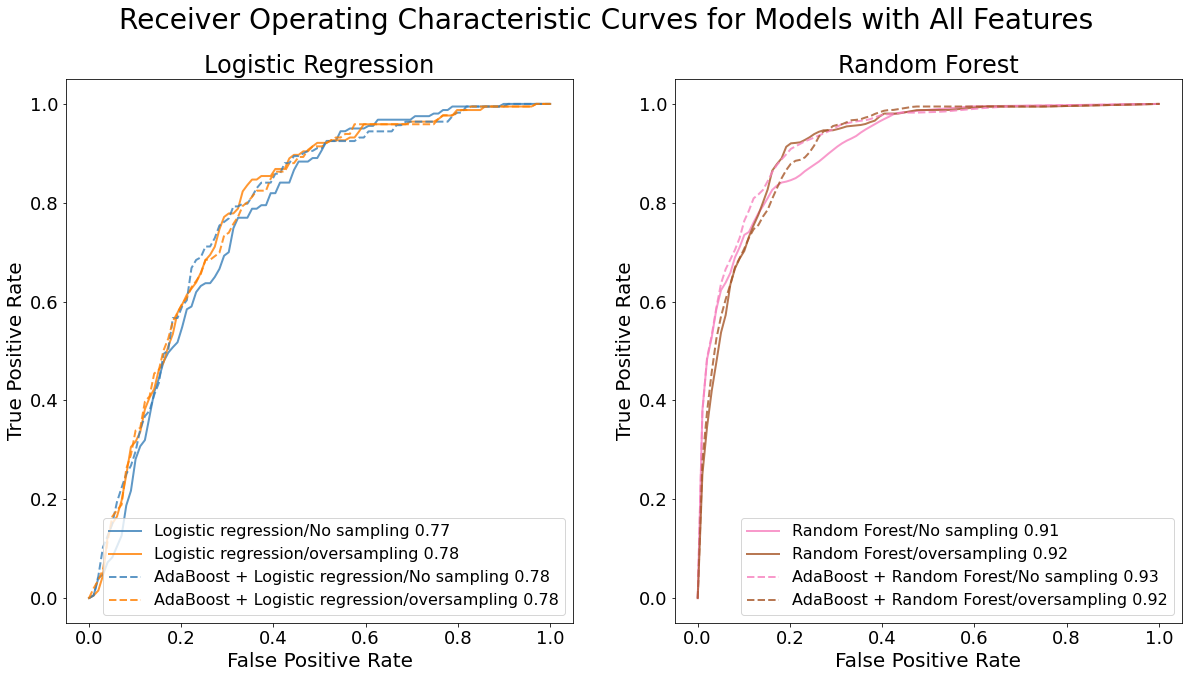

In [7]:
# Convert the df for each method into numpy array
X = df.to_numpy()
# Convert the dependent into numpy array (same for the 3 methods)
y = dep_var.to_numpy()
# Name of the logistic regression methods
method_name = ['Logistic regression', 'Random Forest', 'Gradient Boosting', 'KNN', 'SVM']

sampling_methods=[None, SMOTE, NearMiss]
sampling_names=['No sampling', 'oversampling', 'undersampling']
# Colorblind color palette
color = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']

# Create a multiplot
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))
fig.suptitle('Receiver Operating Characteristic Curves for Models with All Features', fontsize=28)

print('LR')        
for i in range(0,2):
    # 10-fold cross-validation 
    mean_fpr,mean_tpr,mean_f1 = roc_10fold_crossvalidation(X,y, LogisticRegression(random_state=42, penalty='none', max_iter=100000), sampling_methods[i])
    print(mean_f1)
    # Calculate the auc score
    mean_auc = auc(mean_fpr,mean_tpr)
    # Plot ROC and auc score in the legends, rounded up to 2 decimals
    ax1.plot(mean_fpr, mean_tpr, color=color[i], label=method_name[0]+'/'+sampling_names[i] +' %.2f'%mean_auc, lw=2, alpha=.8)
# Plot the 2 methods with uncorrected Logits 
for i in range(0,2):    
    # 10-fold cross-validation 
    mean_fpr,mean_tpr, mean_f1 = roc_10fold_crossvalidation(X,y, AdaBoostClassifier(LogisticRegression(random_state=42, penalty='none', max_iter=100000), n_estimators=100, random_state=0), sampling_methods[i])
    print(mean_f1)
    # Calculate the auc score
    mean_auc = auc(mean_fpr,mean_tpr)
    # Plot ROC and auc score in the legends, rounded up to 2 decimals
    ax1.plot(mean_fpr, mean_tpr, color=color[i], ls='--', label='AdaBoost + '+method_name[0]+'/'+sampling_names[i] +' %.2f'%mean_auc, lw=2, alpha=.8)

print('RF')    
#random forest 
for i in range(0,2):
    # 10-fold cross-validation 
    mean_fpr,mean_tpr, mean_f1 = roc_10fold_crossvalidation(X,y, RandomForestClassifier(random_state=42), sampling_methods[i])
    print(mean_f1)
    # Calculate the auc score
    mean_auc = auc(mean_fpr,mean_tpr)
    # Plot ROC and auc score in the legends, rounded up to 2 decimals
    ax2.plot(mean_fpr, mean_tpr, color=color[i+3], label=method_name[1]+'/'+sampling_names[i] +' %.2f'%mean_auc, lw=2, alpha=.8)
# Plot the 3 methods with uncorrected Logits 
for i in range(0,2):    
    # 10-fold cross-validation 
    mean_fpr,mean_tpr, mean_f1 = roc_10fold_crossvalidation(X,y, AdaBoostClassifier(RandomForestClassifier(random_state=42), n_estimators=100, random_state=0), sampling_methods[i])
    print(mean_f1)
    # Calculate the auc score
    mean_auc = auc(mean_fpr,mean_tpr)
    # Plot ROC and auc score in the legends, rounded up to 2 decimals
    ax2.plot(mean_fpr, mean_tpr, color=color[i+3], ls='--', label='AdaBoost + '+ method_name[1] +'/'+sampling_names[i] +' %.2f'%mean_auc, lw=2, alpha=.8)
    
# Set axis labels
ax1.set_ylabel('True Positive Rate', fontsize = 20) # Y label
ax1.set_xlabel('False Positive Rate', fontsize = 20) # X label
ax2.set_ylabel('True Positive Rate', fontsize = 20) # Y label
ax2.set_xlabel('False Positive Rate', fontsize = 20) # X label

# Set titles
ax1.set_title('Logistic Regression', fontsize = 24)
ax2.set_title('Random Forest', fontsize = 24)

ax1.tick_params(labelsize=18)
ax2.tick_params(labelsize=18)

# Show the legend (loc 4 is bottom-right)
ax1.legend(loc=4, fontsize = 16)
ax2.legend(loc=4, fontsize = 16)  

plt.savefig('LR_RF_separate_figures_replication_all_features.png', dpi=1200)    
plt.show()

# 2) Gradient Boosting

Next we test with gradient boosting classifier, whch shows a higher prediction accuracy than the other methods.

GB
0.22750302222550794
0.3539445827430809


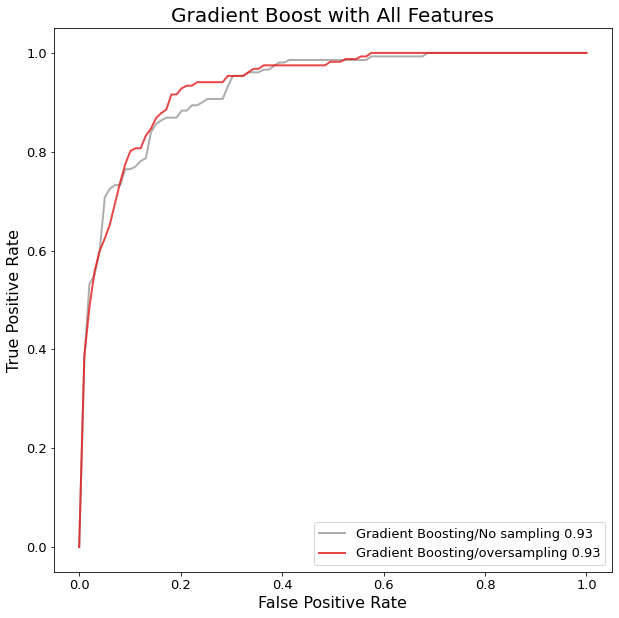

In [10]:
fig2, ax2 = plt.subplots(1, 1,figsize=(10,10))

print('GB')    
#gradient boosting
for i in range(0,2):
    # 10-fold cross-validation 
    mean_fpr,mean_tpr, mean_f1 = roc_10fold_crossvalidation(X,y, GradientBoostingClassifier(), sampling_methods[i])
    print(mean_f1)
    # Calculate the auc score
    mean_auc = auc(mean_fpr,mean_tpr)
    # Plot ROC and auc score in the legends, rounded up to 2 decimals
    ax2.plot(mean_fpr, mean_tpr, color=color[i+6], label=method_name[2]+'/'+sampling_names[i] +' %.2f'%mean_auc, lw=2, alpha=.8)
    
# Set axis labels
ax2.set_ylabel('True Positive Rate', fontsize = 18) # Y label
ax2.set_xlabel('False Positive Rate', fontsize = 18) # X label

# Set titles
ax2.set_title('Gradient Boost with All Features', fontsize = 20)
ax2.tick_params(labelsize=16)

# Show the legend (loc 4 is bottom-right)
ax2.legend(loc=4, fontsize = 16)  

plt.savefig('gradient_boost_all_features.png', dpi=1200)
plt.show()

# 3) KNN Classifier

Here we test the predictive performance of the K nearest neighbor classifier according to different number of k (neighbors)
We note that by increasing K and oversampling, we get higher F1 and AUC scores. However, going beyond 20 neighbours the classifier's F1 score becomes 0 and therefore we do not use more 20 neighbours. 

In [8]:
def KNN_train(features, labels, neighbors, sampling=None):
    X =features 
    y =labels
    
    if sampling:
        model = make_pipeline_imb(sampling(), KNeighborsClassifier(n_neighbors = neighbors))
    else:
        model = KNeighborsClassifier(n_neighbors = neighbors)
    
    y_pred = cross_val_predict(model, X, y, cv=10, method = 'predict_proba')
    y_pred_2 = cross_val_predict(model, X, y, cv=10, method = 'predict')
    fpr, tpr, thresholds = metrics.roc_curve(y, y_pred[:,1])
    auc = roc_auc_score(y, y_pred[:,1])
    f1 = f1_score(y, y_pred_2)
#     print(f1)
    return fpr, tpr, f1, auc

In [9]:
KNN_model_score = pd.DataFrame()

k_min = 1
k_max = 21
l = len(range(k_min,k_max))

neighbors = np.empty(l, dtype=object)

FPR = np.empty(l, dtype=object)
TPR = np.empty(l, dtype=object)
F1 = np.empty(l, dtype=object)
AUC = np.empty(l, dtype=object)

FPR_smote = np.empty(l, dtype=object)
TPR_smote = np.empty(l, dtype=object)
F1_smote = np.empty(l, dtype=object)
AUC_smote = np.empty(l, dtype=object)

features = df.copy()
y_labels = data["warstds"]

for idx, i in enumerate(range(k_min, k_max)):
    [fpr, tpr, f1, auc] = KNN_train(features,y_labels, neighbors = i, sampling = None)
    [fpr_smote, tpr_smote, f1_smote, auc_smote] = KNN_train(features,y_labels, neighbors = i, sampling = SMOTE)

#     print(i)
    neighbors[idx] = i
    FPR[idx] = fpr
    TPR[idx] = tpr
    F1[idx] = f1    
    AUC[idx] = auc
    FPR_smote[idx] = fpr_smote
    TPR_smote[idx] = tpr_smote
    F1_smote[idx] = f1_smote
    AUC_smote[idx] = auc_smote
    
KNN_model_score['neighbors'] = neighbors
KNN_model_score['AUC no sampling'] = AUC
KNN_model_score['AUC with sampling'] = AUC_smote
KNN_model_score['F1 no sampling'] = F1
KNN_model_score['F1 with sampling'] = F1_smote

KNN_model_score['FPR no sampling'] = FPR
KNN_model_score['FPR with sampling'] = FPR_smote
KNN_model_score['TPR no sampling'] = TPR
KNN_model_score['TPR with sampling'] = TPR_smote

print('KNN analysis with and without sampling')
KNN_model_score[['neighbors','AUC no sampling','AUC with sampling','F1 no sampling', 'F1 with sampling']]

KNN analysis with and without sampling


,neighbors,AUC no sampling,AUC with sampling,F1 no sampling,F1 with sampling
0,1,0.530447,0.628724,0.0509091,0.0564769
1,2,0.555555,0.634892,0.019802,0.0578199
2,3,0.559867,0.636065,0.0574713,0.0534979
3,4,0.575606,0.640776,0.025,0.0577089
4,5,0.587084,0.644516,0.0564972,0.0559441
5,6,0.584835,0.643501,0.015625,0.0562181
6,7,0.584612,0.647463,0.0714286,0.0535299
7,8,0.578956,0.642991,0.0625,0.0538876
8,9,0.580557,0.635619,0.0888889,0.052712
9,10,0.587821,0.638998,0.046875,0.0531835


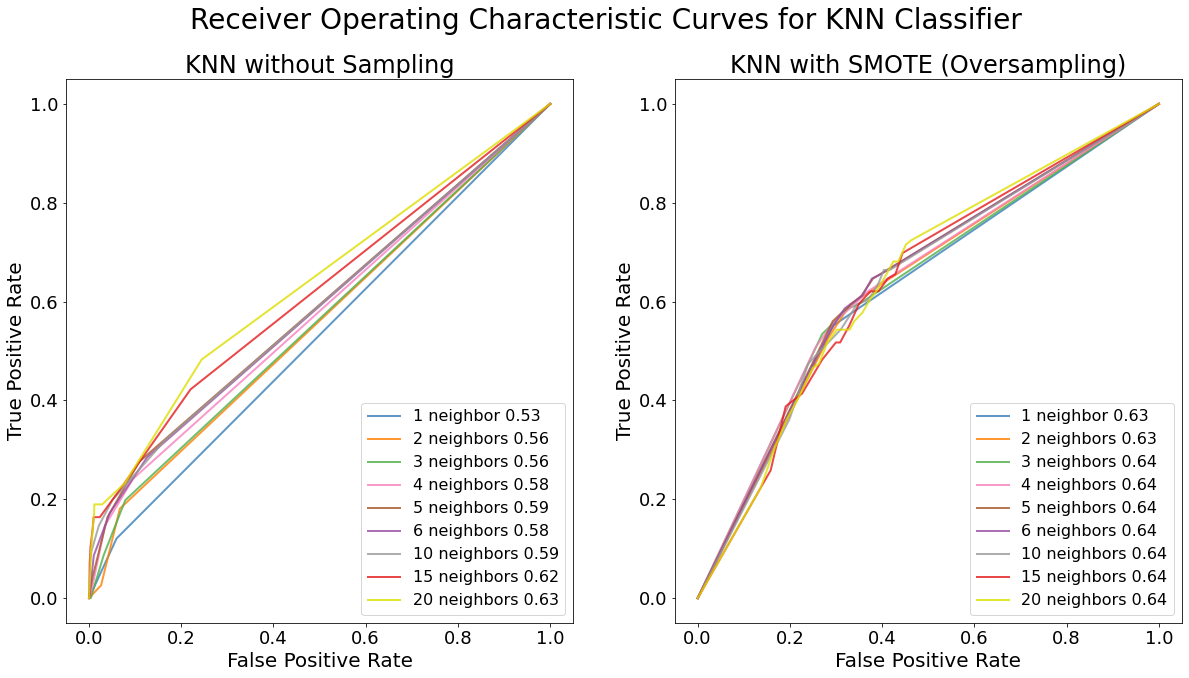

In [10]:
method = ['Logistic regression', 'Random Forest', 'Gradient Boosting', 'KNN', 'SVM']
sampling_methods=[None, SMOTE, NearMiss]
sampling_names=['No sampling', 'SMOTE (oversampling)', 'NearMiss (undersampling)']
# Colorblind color palette
color = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))

ax1.plot(FPR[0], TPR[0], color=color[0], label =  str(neighbors[0]) +' neighbor' +' %.2f'%AUC[0], lw=2, alpha=.8)
ax1.plot(FPR[1], TPR[1], color=color[1], label= str(neighbors[1]) +' neighbors' +' %.2f'%AUC[1], lw=2, alpha=.8)
ax1.plot(FPR[2], TPR[2], color=color[2], label= str(neighbors[2]) +' neighbors' +' %.2f'%AUC[2], lw=2, alpha=.8)
ax1.plot(FPR[3], TPR[3], color=color[3], label= str(neighbors[3]) +' neighbors' + ' %.2f'%AUC[3], lw=2, alpha=.8)
ax1.plot(FPR[4], TPR[4], color=color[4], label= str(neighbors[4]) +' neighbors' + ' %.2f'%AUC[4], lw=2, alpha=.8)
ax1.plot(FPR[5], TPR[5], color=color[5], label= str(neighbors[5]) +' neighbors' + ' %.2f'%AUC[5], lw=2, alpha=.8)
ax1.plot(FPR[9], TPR[9], color=color[6], label= str(neighbors[9]) +' neighbors' +' %.2f'%AUC[9], lw=2, alpha=.8)
ax1.plot(FPR[14], TPR[14], color=color[7], label= str(neighbors[14]) +' neighbors' + ' %.2f'%AUC[14], lw=2, alpha=.8)
ax1.plot(FPR[19], TPR[19], color=color[8], label= str(neighbors[19]) +' neighbors' + ' %.2f'%AUC[19], lw=2, alpha=.8)

ax2.plot(FPR_smote[0], TPR_smote[0], color=color[0], label= str(neighbors[0]) +' neighbor' + ' %.2f'%AUC_smote[0], lw=2, alpha=.8)
ax2.plot(FPR_smote[1], TPR_smote[1], color=color[1], label= str(neighbors[1]) +' neighbors' + ' %.2f'%AUC_smote[1], lw=2, alpha=.8)
ax2.plot(FPR_smote[2], TPR_smote[2], color=color[2], label= str(neighbors[2]) +' neighbors' + ' %.2f'%AUC_smote[2], lw=2, alpha=.8)
ax2.plot(FPR_smote[3], TPR_smote[3], color=color[3], label= str(neighbors[3]) +' neighbors' + ' %.2f'%AUC_smote[3], lw=2, alpha=.8)
ax2.plot(FPR_smote[4], TPR_smote[4], color=color[4], label= str(neighbors[4]) +' neighbors' + ' %.2f'%AUC_smote[4], lw=2, alpha=.8)
ax2.plot(FPR_smote[5], TPR_smote[5], color=color[5], label= str(neighbors[5]) +' neighbors' + ' %.2f'%AUC_smote[5], lw=2, alpha=.8)
ax2.plot(FPR_smote[9], TPR_smote[9], color=color[6], label= str(neighbors[9]) +' neighbors' + ' %.2f'%AUC_smote[9], lw=2, alpha=.8)
ax2.plot(FPR_smote[14],TPR_smote[14], color=color[7], label= str(neighbors[14]) +' neighbors' + ' %.2f'%AUC_smote[14], lw=2, alpha=.8)
ax2.plot(FPR_smote[19],TPR_smote[19], color=color[8], label= str(neighbors[19]) +' neighbors' + ' %.2f'%AUC_smote[19], lw=2, alpha=.8)

fig.suptitle('Receiver Operating Characteristic Curves for KNN Classifier', fontsize=28)

ax1.set_ylabel('True Positive Rate', fontsize = 20) # Y label
ax1.set_xlabel('False Positive Rate', fontsize = 20) # X label
ax2.set_ylabel('True Positive Rate', fontsize = 20) # Y label
ax2.set_xlabel('False Positive Rate', fontsize = 20) # X label

# Set titles
ax1.set_title('KNN without Sampling', fontsize = 24)
ax2.set_title('KNN with SMOTE (Oversampling)', fontsize = 24)

ax1.tick_params(labelsize=18)
ax2.tick_params(labelsize=18)

# Show the legend (loc 4 is bottom-right)
ax1.legend(loc=4, fontsize = 16)
ax2.legend(loc=4, fontsize = 16)    
plt.savefig('KNN.png', dpi=1200)
plt.show()

# 4) SVM Classifier

Here we first try differenet kernels (linear, polynomial, rbf, sigmoid) and regularizers (c = 0.001, 0.01, 0.1, 1) for the SVM classifier and report their performance as shown below.

We notice that SVM does not work well with the Civil War Dataset.

In [22]:
def SVC_train(features, labels, c, kernel, sampling = None):
    
    X = features
    y = labels

    probability = True
    
    classifier = SVC(C=c, kernel = kernel, probability = probability, class_weight = 'balanced', random_state = 42,max_iter = 1000)    

    if sampling:
        model = make_pipeline_imb(sampling(), classifier)
    else:
        model = classifier
   
    y_pred = cross_val_predict(model, X, y, cv=10, method = 'predict_proba')
    y_pred_2 = cross_val_predict(model, X, y, cv=10, method = 'predict')
    fpr, tpr, thresholds = metrics.roc_curve(y, y_pred[:,1])
    auc = roc_auc_score(y, y_pred[:,1])
    f1 = f1_score(y, y_pred_2)

    return fpr, tpr, f1, auc

In [6]:
SVC_model_score = pd.DataFrame()

features = df.copy()
y_labels = data["warstds"]

c = [0.001, 0.01, 0.1, 1]
kernels = ['linear','poly','rbf','sigmoid']

l = len(c)*len(kernels)
regularizer = np.empty(l, dtype=object)
kernel = np.empty(l, dtype=object)
FPR = np.empty(l, dtype=object)
TPR = np.empty(l, dtype=object)
F1 = np.empty(l, dtype=object)
AUC = np.empty(l, dtype=object)
FPR_smote = np.empty(l, dtype=object)
TPR_smote = np.empty(l, dtype=object)
F1_smote = np.empty(l, dtype=object)
AUC_smote = np.empty(l, dtype=object)

idx = 0
for i in c:
    for j in kernels:
        print(j)
        [fpr, tpr, f1, auc] = SVC_train(features, y_labels, i, j, sampling = None)
        [fpr_smote, tpr_smote, f1_smote, auc_smote] = SVC_train(features, y_labels, i, j, sampling = SMOTE)

        regularizer[idx] = i
        kernel[idx] = j
        FPR[idx] = fpr
        TPR[idx] = tpr
        F1[idx] = f1    
        AUC[idx] = auc
        
        FPR_smote[idx] = fpr_smote
        TPR_smote[idx] = tpr_smote
        F1_smote[idx] = f1_smote
        AUC_smote[idx] = auc_smote

        idx +=1

SVC_model_score['kernel'] = kernel
SVC_model_score['regularizer'] = regularizer
SVC_model_score['AUC no sampling'] = AUC
SVC_model_score['AUC with sampling'] = AUC_smote
SVC_model_score['F1 no sampling'] = F1
SVC_model_score['F1 with sampling'] = F1_smote

SVC_model_score['FPR no sampling'] = FPR
SVC_model_score['FPR with sampling'] = FPR_smote
SVC_model_score['TPR no sampling'] = TPR
SVC_model_score['TPR with sampling'] = TPR_smote

print('SVM analysis with and without sampling')
SVC_model_score[['kernel', 'regularizer','AUC no sampling','AUC with sampling','F1 no sampling', 'F1 with sampling']]

linear
poly
rbf
sigmoid
linear
poly
rbf
sigmoid
linear
poly
rbf
sigmoid
linear
poly
rbf
sigmoid
SVM analysis with and without sampling


,kernel,regularizer,AUC no sampling,AUC with sampling,F1 no sampling,F1 with sampling
0,linear,0.001,0.504977,0.501288,0.0332326,0.0311265
1,poly,0.001,0.484805,0.515034,0,0.0318736
2,rbf,0.001,0.452839,0.486302,0,0.0282835
3,sigmoid,0.001,0.520468,0.484217,0,0.0297971
4,linear,0.01,0.547051,0.498547,0.0278269,0.0277008
5,poly,0.01,0.477368,0.504757,0,0.0318736
6,rbf,0.01,0.551327,0.497545,0,0.0318369
7,sigmoid,0.01,0.518574,0.440047,0,0.0295567
8,linear,0.1,0.498165,0.509571,0.0297644,0.0294817
9,poly,0.1,0.494383,0.49431,0.0292553,0.0318736


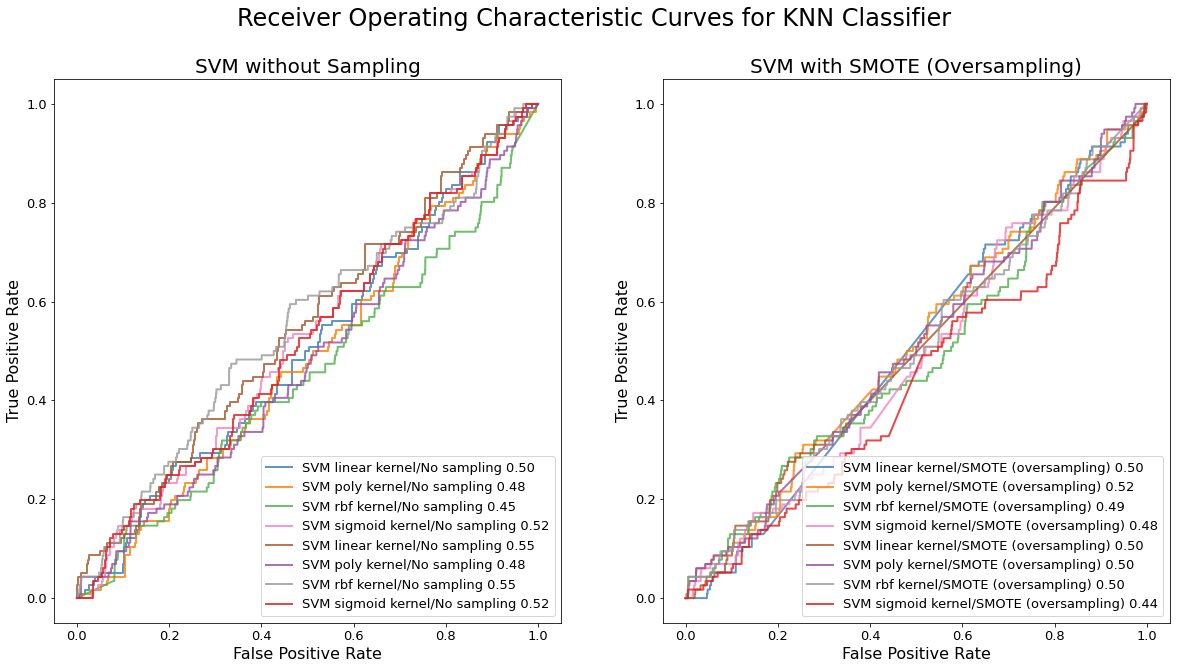

In [12]:
method = ['Logistic regression', 'Random Forest', 'Gradient Boosting', 'KNN', 'SVM']
sampling_methods=[None, SMOTE, NearMiss]
sampling_names=['No sampling', 'SMOTE (oversampling)', 'NearMiss (undersampling)']
# Colorblind color palette
color = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))

ax1.plot(FPR[0], TPR[0], color=color[0], label=method[4] + ' ' + str(kernel[0]) +' kernel' +'/'+ sampling_names[0] +' %.2f'%AUC[0], lw=2, alpha=.8)
ax1.plot(FPR[1], TPR[1], color=color[1], label=method[4] + ' ' + str(kernel[1]) +' kernel' '/'+ sampling_names[0]+' %.2f'%AUC[1], lw=2, alpha=.8)
ax1.plot(FPR[2], TPR[2], color=color[2], label=method[4]+ ' ' + str(kernel[2]) +' kernel' '/'+ sampling_names[0]+' %.2f'%AUC[2], lw=2, alpha=.8)
ax1.plot(FPR[3], TPR[3], color=color[3], label=method[4]+ ' ' + str(kernel[3]) +' kernel' '/'+ sampling_names[0]+' %.2f'%AUC[3], lw=2, alpha=.8)
ax1.plot(FPR[4], TPR[4], color=color[4], label=method[4]+ ' ' + str(kernel[4]) +' kernel' '/'+ sampling_names[0]+' %.2f'%AUC[4], lw=2, alpha=.8)
ax1.plot(FPR[5], TPR[5], color=color[5], label=method[4]+ ' ' + str(kernel[5]) +' kernel' '/'+ sampling_names[0]+' %.2f'%AUC[5], lw=2, alpha=.8)
ax1.plot(FPR[6], TPR[6], color=color[6], label=method[4]+ ' ' + str(kernel[6]) +' kernel' '/'+ sampling_names[0]+' %.2f'%AUC[6], lw=2, alpha=.8)
ax1.plot(FPR[7], TPR[7], color=color[7], label=method[4]+ ' ' + str(kernel[7]) +' kernel' '/'+ sampling_names[0]+' %.2f'%AUC[7], lw=2, alpha=.8)

ax2.plot(FPR_smote[0], TPR_smote[0], color=color[0], label=method[4] + ' ' + str(kernel[8]) +' kernel' +'/'+ sampling_names[1] +' %.2f'%AUC_smote[0], lw=2, alpha=.8)
ax2.plot(FPR_smote[1], TPR_smote[1], color=color[1], label=method[4] + ' ' + str(kernel[9]) +' kernel' '/'+ sampling_names[1]+' %.2f'%AUC_smote[1], lw=2, alpha=.8)
ax2.plot(FPR_smote[2], TPR_smote[2], color=color[2], label=method[4]+ ' ' + str(kernel[10]) +' kernel' '/'+ sampling_names[1]+' %.2f'%AUC_smote[2], lw=2, alpha=.8)
ax2.plot(FPR_smote[3], TPR_smote[3], color=color[3], label=method[4]+ ' ' + str(kernel[11]) +' kernel' '/'+ sampling_names[1]+' %.2f'%AUC_smote[3], lw=2, alpha=.8)
ax2.plot(FPR_smote[4], TPR_smote[4], color=color[4], label=method[4]+ ' ' + str(kernel[12]) +' kernel' '/'+ sampling_names[1]+' %.2f'%AUC_smote[4], lw=2, alpha=.8)
ax2.plot(FPR_smote[5], TPR_smote[5], color=color[5], label=method[4]+ ' ' + str(kernel[13]) +' kernel' '/'+ sampling_names[1]+' %.2f'%AUC_smote[5], lw=2, alpha=.8)
ax2.plot(FPR_smote[6], TPR_smote[6], color=color[6], label=method[4]+ ' ' + str(kernel[14]) +' kernel' '/'+ sampling_names[1]+' %.2f'%AUC_smote[6], lw=2, alpha=.8)
ax2.plot(FPR_smote[7], TPR_smote[7], color=color[7], label=method[4]+ ' ' + str(kernel[15]) +' kernel' '/'+ sampling_names[1]+' %.2f'%AUC_smote[7], lw=2, alpha=.8)

fig.suptitle('Receiver Operating Characteristic Curves for SVM Classifier', fontsize=24)

ax1.set_ylabel('True Positive Rate', fontsize = 16) # Y label
ax1.set_xlabel('False Positive Rate', fontsize = 16) # X label
ax2.set_ylabel('True Positive Rate', fontsize = 16) # Y label
ax2.set_xlabel('False Positive Rate', fontsize = 16) # X label

# Set titles
ax1.set_title('SVM without Sampling', fontsize = 20)
ax2.set_title('SVM with SMOTE (Oversampling)', fontsize = 20)

ax1.tick_params(labelsize=13)
ax2.tick_params(labelsize=13)

# Show the legend (loc 4 is bottom-right)
ax1.legend(loc=4, fontsize = 16)
ax2.legend(loc=4, fontsize = 16)   
# plt.savefig('SVM_2.png', dpi=1200)
plt.show()

In [11]:
def linear_SVC_train(features, labels, c, sampling = None):
    X = features
    y = labels
    p = 'l2'
    loss = ['hinge', 'squared_hinge']

    classifier = LinearSVC(C=c, loss ='squared_hinge',  penalty = p, class_weight = None, random_state = 42, max_iter = 1000) 

    if sampling:
        model = make_pipeline_imb(sampling(), classifier)
    else:
        model = classifier

    y_pred_2 = cross_val_predict(model, X, y, cv=10, method = 'predict')
    fpr, tpr, thresholds = metrics.roc_curve(y, y_pred_2)
    auc = roc_auc_score(y, y_pred_2)
    f1 = f1_score(y, y_pred_2)

    return fpr, tpr, f1, auc


In [12]:
linear_SVC_model_score = pd.DataFrame()

features = df.copy()
y_labels = data["warstds"]

c = [0.001, 0.01, 0.1, 1]
l = len(c)
regularizer = np.empty(l, dtype=object)

FPR = np.empty(l, dtype=object)
TPR = np.empty(l, dtype=object)
F1 = np.empty(l, dtype=object)
AUC = np.empty(l, dtype=object)

FPR_smote = np.empty(l, dtype=object)
TPR_smote = np.empty(l, dtype=object)
F1_smote = np.empty(l, dtype=object)
AUC_smote = np.empty(l, dtype=object)

idx = 0
for i in c:
    [fpr, tpr, f1, auc] = linear_SVC_train(features, y_labels, i, sampling = None)
    [fpr_smote, tpr_smote, f1_smote, auc_smote] = linear_SVC_train(features, y_labels, i, sampling = SMOTE)

    regularizer[idx] = i
    FPR[idx] = fpr
    TPR[idx] = tpr
    F1[idx] = f1    
    AUC[idx] = auc
    FPR_smote[idx] = fpr_smote
    TPR_smote[idx] = tpr_smote
    F1_smote[idx] = f1_smote
    AUC_smote[idx] = auc_smote
        
    idx +=1

linear_SVC_model_score['regularizer'] = regularizer
linear_SVC_model_score['AUC no sampling'] = AUC
linear_SVC_model_score['AUC with sampling'] = AUC_smote
linear_SVC_model_score['F1 no sampling'] = F1
linear_SVC_model_score['F1 with sampling'] = F1_smote

linear_SVC_model_score['FPR no sampling'] = FPR
linear_SVC_model_score['FPR with sampling'] = FPR_smote
linear_SVC_model_score['TPR no sampling'] = TPR
linear_SVC_model_score['TPR with sampling'] = TPR_smote

print('SVM analysis with and without sampling')
linear_SVC_model_score[['regularizer','AUC no sampling','AUC with sampling','F1 no sampling', 'F1 with sampling']]

SVM analysis with and without sampling


,regularizer,AUC no sampling,AUC with sampling,F1 no sampling,F1 with sampling
0,0.001,0.509696,0.619637,0.0353982,0.045283
1,0.01,0.510557,0.620739,0.0356083,0.0478469
2,0.1,0.509347,0.585944,0.0338983,0.0479512
3,1,0.509347,0.598222,0.0338983,0.0449711


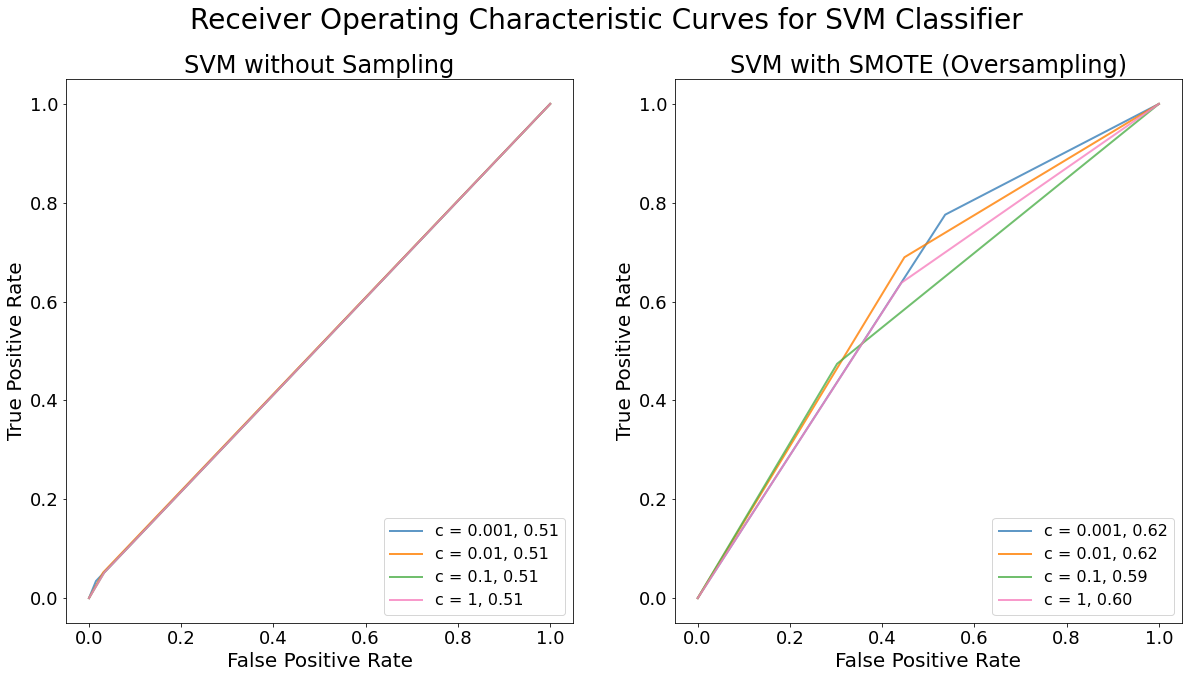

In [13]:
method = ['Logistic regression', 'Random Forest', 'Gradient Boosting', 'KNN', 'SVM']
sampling_methods=[None, SMOTE, NearMiss]
sampling_names=['No sampling', 'SMOTE (oversampling)', 'NearMiss (undersampling)']
# Colorblind color palette
color = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00']

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))

ax1.plot(FPR[0], TPR[0], color=color[0], label= 'c = ' + str(regularizer[0]) +', %.2f'%AUC[0], lw=2, alpha=.8)
ax1.plot(FPR[1], TPR[1], color=color[1], label='c = ' + str(regularizer[1]) +', %.2f'%AUC[1], lw=2, alpha=.8)
ax1.plot(FPR[2], TPR[2], color=color[2], label='c = ' + str(regularizer[2]) +', %.2f'%AUC[2], lw=2, alpha=.8)
ax1.plot(FPR[3], TPR[3], color=color[3], label='c = ' + str(regularizer[3]) +', %.2f'%AUC[3], lw=2, alpha=.8)

ax2.plot(FPR_smote[0], TPR_smote[0], color=color[0], label='c = ' + str(regularizer[0]) +', %.2f'%AUC_smote[0], lw=2, alpha=.8)
ax2.plot(FPR_smote[1], TPR_smote[1], color=color[1], label='c = ' + str(regularizer[1]) +', %.2f'%AUC_smote[1], lw=2, alpha=.8)
ax2.plot(FPR_smote[2], TPR_smote[2], color=color[2], label='c = ' + str(regularizer[2]) +', %.2f'%AUC_smote[2], lw=2, alpha=.8)
ax2.plot(FPR_smote[3], TPR_smote[3], color=color[3], label='c = ' + str(regularizer[3]) + ', %.2f'%AUC_smote[3], lw=2, alpha=.8)

fig.suptitle('Receiver Operating Characteristic Curves for SVM Classifier', fontsize=28)

ax1.set_ylabel('True Positive Rate', fontsize = 20) # Y label
ax1.set_xlabel('False Positive Rate', fontsize = 20) # X label
ax2.set_ylabel('True Positive Rate', fontsize = 20) # Y label
ax2.set_xlabel('False Positive Rate', fontsize = 20) # X label

# Set titles
ax1.set_title('SVM without Sampling', fontsize = 24)
ax2.set_title('SVM with SMOTE (Oversampling)', fontsize = 24)

ax1.tick_params(labelsize=18)
ax2.tick_params(labelsize=18)

# Show the legend (loc 4 is bottom-right)
ax1.legend(loc=4, fontsize = 16)
ax2.legend(loc=4, fontsize = 16)    
plt.savefig('linear_SVM.png', dpi=1200)
plt.show()